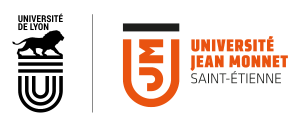

<center><span style="font-size:35px"><b>Advanced Machine Learning</b></span><br><br><span style="font-size:25px">Proximal Splitting Algorithms</span></center>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd

# PART 1: Feature Selection with Lasso

The **Least Absolute Shrinkage and Selection Operator (LASSO)** is a mathematical operator used in linear regression use to penalize the absolute values of regression coefficients, encouraging some coefficients to be exactly zero. This helps with feature selection and model simplification by reducing the number of relevant variables considered in the model. More formally, given some input matrix $X\in\mathbb{R}^{m\times n}$ and some output vector $y\in\mathbb{R}^m$, it finds a linear relationship $y \approx X \hat{w}$ where

$$\begin{equation}\hat{w}=\underset{w\in\mathbb{R}^n}{\mathrm{argmin}}\; \frac{1}{2}\| y - Xw\|_2^2 + \lambda \| w\|_1\quad\text{with}\quad\lambda>0\end{equation}$$

The regularization parameter $\lambda>0$ has to be selected in order to tune the right balance the data fidelity and regularization terms.

# 1.1. Dataset and Preprocessing

We consider the following *House Prices* dataset [1].

> Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.
>
> With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, your goal is to predict the final price of each home.



**Exercice:** Load the data from the file *train.csv* by using pandas. Comment the data.

In [3]:
data = pd.read_csv('data/train.csv')
print(data.shape)
data

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


**Exercice:** We consider the following preprocessing where 1) the categorial features are converted into numerical features by using the function *LabelEncoder* and 2) the instances with *NaN* values are removed by resorting to the function *dropna* of the Pandas library. Comment.

In [4]:
from sklearn.preprocessing import LabelEncoder
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
non_numeric_cols = data.select_dtypes(exclude=numerics).columns

le = LabelEncoder()
for col in non_numeric_cols:
    data[col] = le.fit_transform(data[col])
data = data.dropna()


**Exercice:** In the following, we would like to predict the *SalePrice* (denoted $y$) of the house from all the other different features (denoted $X$). Extract $\{X,y\}$ from the data. You might resort to *.drop* from the Pandas library. Then, convert them to numpy arrays.

In [5]:
X,y = data.drop(labels=['SalePrice'], axis=1), data['SalePrice']
X, y = X.to_numpy(), y.to_numpy()

**Exercice:** Split the dataset into training and validation sets of same sizes. To do so, use the function *train_test_split* from sklearn with random_state 42.

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.5, random_state=42)



**Exercice:** Let us consider the following preprocessing. Comment.

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)


scaler_target = StandardScaler()
scaler_target.fit(y_train[:,None])

y_train = scaler_target.fit_transform(y_train[:,None])[:,0]
y_valid = scaler_target.fit_transform(y_valid[:,None])[:,0]

## 1.2. Forward-Backward Solver

We now turn to the actual solving the LASSO problem. To this purpose, we propose to implement a forward-backward algorithm.

**Exercice:** Identify the smooth and the nonsmooth parts of the objective. Compute the Lipschitz constant of the gradient of the smooth part.

In [8]:
beta = np.linalg.norm(X_train.T@X_train,2)
print(beta)

print(np.linalg.norm(X_train,2)**2)

6301.739189426365
6301.739189426359


**Exercice:** Implement the proximity operator function associated to the nonsmooth part.

In [9]:
def soft_thresholding(u, gamma):
    """ Simple to understand implementation but not the most efficient """
    ind_m = np.argwhere(u<-gamma)
    ind   = np.argwhere((u>=-gamma) & (u<=gamma))
    ind_p = np.argwhere(u>gamma)

    u[ind_m] = u[ind_m] + gamma
    u[ind]   = 0*u[ind]
    u[ind_p] = u[ind_p] - gamma
    
    return u

**Exercice:** Implement the forward-backward algorithm for solving lasso.

In [9]:
class LASSO(object):
    def __init__(self, num_steps=100, lasso_reg=1):
        self.num_steps = int(num_steps)
        self.lasso_reg = lasso_reg
        self.losses = []
        
    def compute_loss(self, y, X, w):
        loss = .5*np.linalg.norm(y-X@w,2)**2 + self.lasso_reg*np.sum(np.abs(w)) 
        self.losses.append(loss)
        return loss
        
    def run(self, y, X):
        n_features = X.shape[1]
        w = np.zeros((n_features))
        
        beta = np.linalg.norm(X,2)**2
        step_size = .99 * (1/beta)
        
        for _ in range(self.num_steps):
            
            """ Forward step """
            w = w - step_size * X.T @ (X @ w - y)
            
            """ Backward step """
            w = soft_thresholding(w, step_size*self.lasso_reg)
            
            """ compute loss """
            self.compute_loss(y,X,w)
        
        return w
        
        

In [10]:
lasso = LASSO(num_steps=1e4, lasso_reg=1e-3)
w = lasso.run(y_train,X_train)

**Exercice:** Add the computation and storing of the loss. Then display it as a function of the iterations

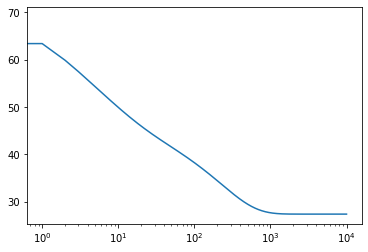

In [11]:
plt.figure()
plt.semilogx(lasso.losses)

**Exercice:** Select the optimal regularization parameter by cross-validation. Comment.

In [12]:
lasso_all = np.logspace(-2,2,10)
val_losses = []
num_relevant_features = []

for lasso_reg in lasso_all:
    lasso = LASSO(num_steps=1e4, lasso_reg=lasso_reg)
    w = lasso.run(y_train,X_train)
    y_valid_prediction = X_valid @ w
    validation_error = .5*np.mean((y_valid - y_valid_prediction)**2)
    val_losses.append(validation_error)
    num_relevant_features.append(len(np.argwhere(w!=0)))
    
    
lasso_reg_opt = lasso_all[np.argmin(val_losses)]
lasso = LASSO(num_steps=1e4, lasso_reg=lasso_reg)
w = lasso.run(y_train,X_train)
w

array([-0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.        ,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.        ,  0.        ,  0.34814565,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.00392104,  0.        ,  0.        ,
       -0.05929922,  0.        , -0.        , -0.        ,  0.        ,
       -0.        ,  0.        , -0.        ,  0.        , -0.        ,
       -0.        ,  0.        ,  0.        ,  0.07569177,  0.        ,
       -0.        ,  0.15526925,  0.        , -0.        ,  0.        ,
        0.        ,  0.        , -0.        , -0.06774614,  0.        ,
        0.        ,  0.        , -0.        , -0.        ,  0.        ,
       -0.        ,  0.09637514,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.        ,  0.  

**Exercice:** Show the validation error and the number of relevant features as functions of the lasso regularization parameter. Comment.

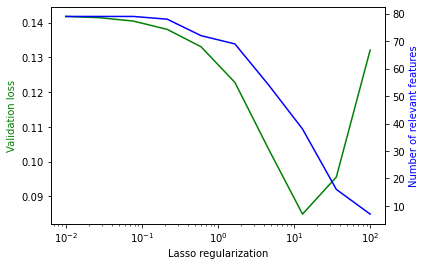

In [13]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.semilogx(lasso_all, val_losses, 'g-')
ax2.semilogx(lasso_all, num_relevant_features, 'b-')

ax1.set_xlabel('Lasso regularization')
ax1.set_ylabel('Validation loss', color='g')
ax2.set_ylabel('Number of relevant features', color='b')

plt.show()

# 1.3. (on demand) Fast Forward-Backward Solver

**Exercice:** Learn and implement the accelerated variant

# PART 2: Piecewise Denoising with Total Variation

The goal of piecewise constant denoising is to enhance the quality of noisy data by identifying and preserving distinct regions with constant intensity values while suppressing noise. This technique is crucial for various applications, including image processing and signal analysis, as it helps improve the accuracy and interpretability of the underlying information by reducing unwanted interference from noise.

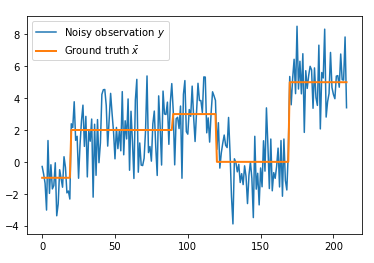

Similarly to feature selection (as in LASSO), piecewise constant denoising can also be considered from the point of view of variational approaches, where the denoised solution minimizes a criterion composed of a data fidelity term and a regularization term. In this part, we focus on the use of total variation (TV) as a regularization term. Penalizing the total variation by a norm favoring parsimony, e.g. $\ell_1$, allows the restored solution to preserve a small number of discontinuities. More formally, $\ell_1$-TV denoising aims at finding an approximation $\hat{x}$ of $y\in\mathbb{R}^n$ that is piecewise constant, i.e., with sparse variations, by solving 
$$\hat{x}=\underset{x\in\mathbb{R}^n}{\mathrm{argmin}}\; \frac{1}{2}\| y - x\|_2^2 + \lambda \| \mathrm{TV}(x)\|_1\quad\text{where}\quad \mathrm{TV}(x)_i = x_{i+1}-x_i\quad\text{and}\quad\lambda>0$$

## 2.1. Data Generation

**Exercice:** Given the following ground truth signal $\bar{x}$, generate a noisy observation $y$ corrupted by gaussian noise with mean $0$ and standard deviation $1.5$.

In [4]:
""" Ground truth """
plateau_val = [-1, 2, 3, 0, 5]
plateau_len = [20, 70, 30, 50, 40]

xbar = np.empty(0)
for val, length in zip(plateau_val, plateau_len):
    xbar = np.concatenate((xbar, val*np.ones((length))), axis=0)    
    
""" Noisy observation """
sigma = 1.5
y = xbar + sigma*np.random.randn(*xbar.shape)

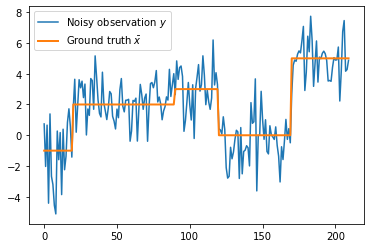

In [6]:
plt.figure()
plt.plot(y, label=r'Noisy observation $y$')
plt.plot(xbar, label=r'Ground truth $\bar{x}$', linewidth=2)
plt.legend()

## 2.2 Dual Forward-Backward Algorithm

**Exercice:** Given the following implementation of the linear operator $L$ modeling the first-order variations, evaluate $\|\mathrm{TV}(y)\|_1$. 

[[-1.  1.  0. ...  0.  0.  0.]
 [ 0. -1.  1. ...  0.  0.  0.]
 [ 0.  0. -1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1.  0.  0.]
 [ 0.  0.  0. ... -1.  1.  0.]
 [ 0.  0.  0. ...  0. -1.  1.]]
296.52513087910484


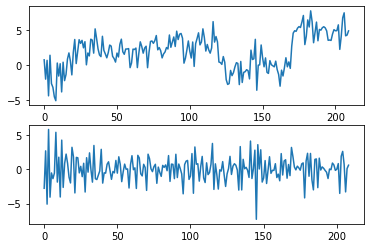

In [8]:
# Linear operator associated to the total variation
Lm = - np.eye(len(y))[:-1,:]
Lp = np.eye(len(y))
Lp = np.hstack((np.zeros((len(y),1)), Lp))[:-1,:-1]
L = Lm + Lp

print(L)
print(np.sum(np.abs(L@y))) # || TV(y) ||_1


plt.figure()
plt.subplot(211)
plt.plot(y)
plt.subplot(212)
plt.plot(L@y)

**Exercice:** Explain why this minimization cannot be solved with forward-backward solver. Write the dual problem.

**Exercice:** Implement a dual forward-backward solver.

In [31]:
class TV_denoising(object):
    def __init__(self, num_steps=100, tv_reg=1):
        self.num_steps = int(num_steps)
        self.tv_reg = tv_reg
        self.losses = []
        self.lin = None
        
    def compute_loss(self, y, x):
        loss = .5*np.linalg.norm(y-x,2)**2 + self.tv_reg*np.sum(np.abs(self.lin @ x)) 
        self.losses.append(loss)
        return loss
       
    def compute_lin_op(self, y):
        Lm = - np.eye(len(y))[:-1,:]
        Lp = np.eye(len(y))
        Lp = np.hstack((np.zeros((len(y),1)), Lp))[:-1,:-1]
        self.lin =  Lm + Lp

    def run(self, y):
        
        """ Compute the linear operator """
        self.compute_lin_op(y)
        
        """ Compute step-size """
        step_size = .99 * (1/(np.linalg.norm(self.lin, 2)**2))
        alpha = 1
        
        """ Init """
        u = np.zeros((len(y)-1))
        
        for _ in range(self.num_steps):
            
            """ Forward step """
            u = u - step_size * self.lin @ (self.lin.T @ u + y)
            
            """ Backward step """
            u = u - step_size*soft_thresholding(u/step_size, self.tv_reg/step_size)
            
            """ compute loss """
            x = y + self.lin.T @ u
            self.compute_loss(y,x)
        
        return x
        

In [32]:
tv_denoising = TV_denoising(tv_reg=22, num_steps=1e4)
x = tv_denoising.run(y)

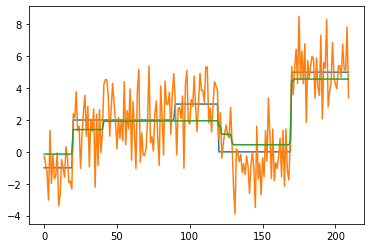

In [33]:
plt.figure()
plt.plot(xbar)
plt.plot(y)
plt.plot(x)


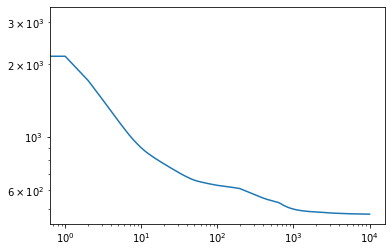

In [34]:
plt.loglog(tv_denoising.losses)

# References

- [1] Anna Montoya, DataCanary. (2016). House Prices - Advanced Regression Techniques. Kaggle. https://kaggle.com/competitions/house-prices-advanced-regression-techniques